<div align="center">
    <h1>DS-210: Programming for Data Science</h1>
    <h1>Lecture 14</h1>
</div>

# 1. Graph exploration overview
# 2. Breadth–first search (BFS)
# 3. Depth–first search (DFS)
# 4. Strongly connected components
# 5. Priority Queues

# <font color="red">1. Graph exploration overview</font>


## Graph exploration

**Sample popular methods:**

* breadth–first search (BFS)
  * uses a queue

* depth–first search (DFS)
  * uses a stack

* random walks
  * example: PageRank (see Homework 7)

## Useful graph subroutines

In [2]:
type Vertex = usize;
type ListOfEdges = Vec<(Vertex,Vertex)>;
type AdjacencyLists = Vec<Vec<Vertex>>;

#[derive(Debug)]
struct Graph {
    n: usize, // vertex labels in {0,...,n-1}
    outedges: AdjacencyLists,
}

// reverse direction of edges on a list
fn reverse_edges(list:&ListOfEdges)
        -> ListOfEdges {
    let mut new_list = vec![];
    for (u,v) in list {
        new_list.push((*v,*u));
    }
    new_list
}

reverse_edges(&vec![(3,2),(1,1),(0,100),(100,0)])

[(2, 3), (1, 1), (100, 0), (0, 100)]

In [3]:
impl Graph {
    fn add_directed_edges(&mut self,
                          edges:&ListOfEdges) {
        for (u,v) in edges {
            self.outedges[*u].push(*v);
        }
    }
    fn sort_graph_lists(&mut self) {
        for l in self.outedges.iter_mut() {
            l.sort();
        }
    }
    fn create_directed(n:usize,edges:&ListOfEdges)
                                            -> Graph {
        let mut g = Graph{n,outedges:vec![vec![];n]};
        g.add_directed_edges(edges);
        g.sort_graph_lists();
        g                                        
    }
    
    fn create_undirected(n:usize,edges:&ListOfEdges)
                                            -> Graph {
        let mut g = Self::create_directed(n,edges);
        g.add_directed_edges(&reverse_edges(edges));
        g.sort_graph_lists();
        g                                        
    }
}

# 1. Graph exploration overview
# <font color="red">2. Breadth–first search (BFS)</font>
# 3. Depth–first search (DFS)
# 4. Strongly connected components

## Sample graph

<div align="center">
    <img src="graphs/graph_1_0.svg" alt="[first sample graph]" width="50%">
</div>

In [4]:
let n: usize = 10;
let mut edges: ListOfEdges = vec![(0,1),(0,2),(1,2),(2,4),(2,3),(4,3),(4,5),(5,6),(4,6),(6,8),(6,7),(8,7),(1,9)];
edges.sort();
println!("{:?}",edges);
let graph = Graph::create_undirected(n,&edges);
for (i, l) in graph.outedges.iter().enumerate() {
    println!("{} {:?}", i, *l);
}

[(0, 1), (0, 2), (1, 2), (1, 9), (2, 3), (2, 4), (4, 3), (4, 5), (4, 6), (5, 6), (6, 7), (6, 8), (8, 7)]
0 [1, 2]
1 [0, 2, 9]
2 [0, 1, 3, 4]
3 [2, 4]
4 [2, 3, 5, 6]
5 [4, 6]
6 [4, 5, 7, 8]
7 [6, 8]
8 [6, 7]
9 [1]


()

## Breadth–first search (BFS)

**General idea:**
* start from some vertex and explore its neighbors (distance 1)
* then explore neighbors of neighbors (distance 2)
* then explore neighbors of neighbors of neighbors (distance 3)
* ...

<div align="center">
    <b>Our example:</b> start from vertex 2<br><br>
</div>   
<div align="center">
    <img src="graphs/graph_1_1.svg" alt="[first sample graph]">
</div>

<div align="center">
    <img src="graphs/graph_1_2.svg" alt="[first sample graph, grouped into layers]">
</div>

## Implementation: compute distances from vertex 2 via BFS

`distance[v]`: distance of `v` from vertex 2 (`None` is unknown)

In [5]:
let start: Vertex = 2; // <= we'll start from this vertex

let mut distance: Vec<Option<u32>> = vec![None;graph.n];
distance[start] = Some(0); // <= we know this distance
distance

[None, None, Some(0), None, None, None, None, None, None, None]

`queue`: vertices to consider, they will arrive layer by layer

In [6]:
use std::collections::VecDeque;
let mut queue: VecDeque<Vertex> = VecDeque::new();
queue.push_back(start);
queue

[2]

## Implementation: compute distances from vertex 2 via BFS
**Main loop:**<br>
&nbsp;&nbsp;$\bullet$ consider vertices one by one<br>
&nbsp;&nbsp;$\bullet$ add their new neighbors to the processing queue

In [8]:
println!("{:?}",queue);
while let Some(v) = queue.pop_front() { // new unprocessed vertex
    println!("top {:?}",queue);
    for u in graph.outedges[v].iter() {
        if let None = distance[*u] { // consider all unprocessed neighbors of v
            distance[*u] = Some(distance[v].unwrap() + 1);
            queue.push_back(*u);
            println!("In {:?}",queue);
        }
    }
};

[2]
top []
In [0]
In [0, 1]
In [0, 1, 3]
In [0, 1, 3, 4]
top [1, 3, 4]
top [3, 4]
In [3, 4, 9]
top [4, 9]
top [9]
In [9, 5]
In [9, 5, 6]
top [5, 6]
top [6]
top []
In [7]
In [7, 8]
top [8]
top []


## Implementation: compute distances from vertex 2 via BFS

Compare results:

<div align="center">
    <img src="graphs/graph_1_2.svg" alt="[layers]">
</div>

In [9]:
print!("vertex:distance");
for v in 0..graph.n {
    print!("   {}:{}",v,distance[v].unwrap());
}
println!();

vertex:distance   0:1   1:1   2:0   3:1   4:1   5:2   6:2   7:3   8:3   9:2


## What if we wanted the distance from all to all?

In [10]:
fn compute_and_print_distance_bfs(start: Vertex, graph: &Graph) {
    let mut distance: Vec<Option<u32>> = vec![None;graph.n];
    distance[start] = Some(0); // <= we know this distance
    let mut queue: VecDeque<Vertex> = VecDeque::new();
    queue.push_back(start);
    while let Some(v) = queue.pop_front() { // new unprocessed vertex
        for u in graph.outedges[v].iter() {
            if let None = distance[*u] { // consider all unprocessed neighbors of v
                distance[*u] = Some(distance[v].unwrap() + 1);
                queue.push_back(*u);
            }
        }
    }
    print!("vertex:distance");
    for v in 0..graph.n {
        print!("   {}:{}",v,distance[v].unwrap());
    }
    println!();
}

for i in 0..graph.n {
    println!("Distances from node {}", i);
    compute_and_print_distance_bfs(i, &graph);
}


Distances from node 0
vertex:distance   0:0   1:1   2:1   3:2   4:2   5:3   6:3   7:4   8:4   9:2
Distances from node 1
vertex:distance   0:1   1:0   2:1   3:2   4:2   5:3   6:3   7:4   8:4   9:1
Distances from node 2
vertex:distance   0:1   1:1   2:0   3:1   4:1   5:2   6:2   7:3   8:3   9:2
Distances from node 3
vertex:distance   0:2   1:2   2:1   3:0   4:1   5:2   6:2   7:3   8:3   9:3
Distances from node 4
vertex:distance   0:2   1:2   2:1   3:1   4:0   5:1   6:1   7:2   8:2   9:3
Distances from node 5
vertex:distance   0:3   1:3   2:2   3:2   4:1   5:0   6:1   7:2   8:2   9:4
Distances from node 6
vertex:distance   0:3   1:3   2:2   3:2   4:1   5:1   6:0   7:1   8:1   9:4
Distances from node 7
vertex:distance   0:4   1:4   2:3   3:3   4:2   5:2   6:1   7:0   8:1   9:5
Distances from node 8
vertex:distance   0:4   1:4   2:3   3:3   4:2   5:2   6:1   7:1   8:0   9:5
Distances from node 9
vertex:distance   0:2   1:1   2:2   3:3   4:3   5:4   6:4   7:5   8:5   9:0


()





# Connected components via BFS

<br><br><br>
*Connected component* (in an undirected graph):

<br>
<div align="center">
a maximal set of vertices that are connected
</div>

<div align="center">
    <img src="graphs/graph_2.svg" alt="[second graph]" width="65%">
</div>

Sample graph:

In [11]:
let n: usize = 9;
let edges: Vec<(Vertex,Vertex)> = vec![(0,1),(0,2),(1,2),(2,4),(0,4),(5,7),(6,8)];
let graph = Graph::create_undirected(n, &edges);

## Discovering vertices of a connected component via BFS
`component[v]`: `v`'s component's number (`None`${}\equiv{}$not assigned yet)

In [12]:
type Component = usize;

fn mark_component_bfs(vertex:Vertex, graph:&Graph, component:&mut Vec<Option<Component>>, component_no:Component) {
    component[vertex] = Some(component_no);
    
    let mut queue = std::collections::VecDeque::new();
    queue.push_back(vertex);
    
    while let Some(v) = queue.pop_front() {
        for w in graph.outedges[v].iter() {
            if let None = component[*w] {
                component[*w] = Some(component_no);
                queue.push_back(*w);
            }
        }
    }
}

## Marking all connected components

Loop over all unassigned vertices and assign component numbers

In [13]:
let mut component: Vec<Option<Component>> = vec![None;n];
let mut component_count = 0;
for v in 0..n {
    if let None = component[v] {
        component_count += 1;
        mark_component_bfs(v, &graph, &mut component, component_count);
    }
};

In [14]:
// Let's verify the assignment!
print!("{} components:\n[  ",component_count);
for v in 0..n {
    print!("{}:{}  ",v,component[v].unwrap());
}
println!("]\n");

4 components:
[  0:1  1:1  2:1  3:2  4:1  5:3  6:4  7:3  8:4  ]



<div align="center">
    <img src="graphs/graph_2.svg" alt="[components]" width="50%">
</div>

# 1. Graph exploration overview
# 2. Breadth–first search (BFS)
# <font color="red">3. Depth–first search (DFS)</font>
# 4. Strongly connected components

## Depth–First Search (DFS)

General idea:
* keep going to an unvisited vertex
* when stuck make a step back and try again

<div align="center">
<img src="graphs/graph_3_1.svg" alt="[dfs demo]" width="60%">
</div>

## Depth–First Search (DFS)

General idea:
* keep going to an unvisited vertex
* when stuck make a step back and try again

<div align="center">
<img src="graphs/graph_3_2.svg" alt="[dfs demo]" width="60%">
</div>

## Depth–First Search (DFS)

General idea:
* keep going to an unvisited vertex
* when stuck make a step back and try again

<div align="center">
<img src="graphs/graph_3_3.svg" alt="[dfs demo]" width="60%">
</div>

## Depth–First Search (DFS)

General idea:
* keep going to an unvisited vertex
* when stuck make a step back and try again

<div align="center">
<img src="graphs/graph_3_4.svg" alt="[dfs demo]" width="60%">
</div>

## Depth–First Search (DFS)

General idea:
* keep moving to an unvisited neighbor
* when stuck make a step back and try again

<div align="center">
<img src="graphs/graph_3_5.svg" alt="[dfs demo]" width="60%">
</div>

## Depth–First Search (DFS)

General idea:
* keep going to an unvisited vertex
* when stuck make a step back and try again

<div align="center">
<img src="graphs/graph_3_6.svg" alt="[dfs demo]" width="60%">
</div>

## Depth–First Search (DFS)

General idea:
* keep going to an unvisited vertex
* when stuck make a step back and try again

<div align="center">
<img src="graphs/graph_3_7.svg" alt="[dfs demo]" width="60%">
</div>

## Depth–First Search (DFS)

General idea:
* keep going to an unvisited vertex
* when stuck make a step back and try again

<div align="center">
<img src="graphs/graph_3_8.svg" alt="[dfs demo]" width="60%">
</div>

## Depth–First Search (DFS)

General idea:
* keep going to an unvisited vertex
* when stuck make a step back and try again

<div align="center">
<img src="graphs/graph_3_9.svg" alt="[dfs demo]" width="60%">
</div>

## Depth–First Search (DFS)

General idea:
* keep going to an unvisited vertex
* when stuck make a step back and try again

<div align="center">
<img src="graphs/graph_3_10.svg" alt="[dfs demo]" width="60%">
</div>

## Depth–First Search (DFS)

General idea:
* keep going to an unvisited vertex
* when stuck make a step back and try again

<div align="center">
<img src="graphs/graph_3_11.svg" alt="[dfs demo]" width="60%">
</div>

## Depth–First Search (DFS)

General idea:
* keep going to an unvisited vertex
* when stuck make a step back and try again

<div align="center">
<img src="graphs/graph_3_12.svg" alt="[dfs demo]" width="60%">
</div>

## Depth–First Search (DFS)

General idea:
* keep going to an unvisited vertex
* when stuck make a step back and try again

<div align="center">
<img src="graphs/graph_3_13.svg" alt="[dfs demo]" width="60%">
</div>

## Depth–First Search (DFS)

General idea:
* keep going to an unvisited vertex
* when stuck make a step back and try again

<div align="center">
<img src="graphs/graph_3_14.svg" alt="[dfs demo]" width="60%">
</div>

## Depth–First Search (DFS)

General idea:
* keep going to an unvisited vertex
* when stuck make a step back and try again

<div align="center">
<img src="graphs/graph_3_15.svg" alt="[dfs demo]" width="60%">
</div>

## Our sample graph from BFS

<div align="center">
    <img src="graphs/graph_1_0.svg" alt="[first sample graph]" width="50%">
</div>

In [15]:
fn dfs(vertex:Vertex, graph: &Graph, d: usize, visited: &mut Vec<bool>, distance: &mut Vec<usize> ){
    for w in graph.outedges[vertex].iter() {
      if visited[*w] == false {
        distance[*w] = d;
        visited[*w] = true;
        dfs(*w, graph, d+1, visited, distance);
      }
    }
}

let n: usize = 10;
let edges: ListOfEdges = vec![(0,1),(0,2),(1,2),(2,4),(2,3),(4,3),(4,5),(5,6),(4,6),(6,8),(6,7),(8,7),(1,9)];
let graph = Graph::create_undirected(n,&edges);
let mut visited = vec![false;graph.n];
let mut distance = vec![0;graph.n];

visited[2] = true;
distance[2] = 0;
dfs(2, &graph, 1, &mut visited, &mut distance);
println!("vertex:distance");
for v in 0..graph.n {
    print!("   {}:{}",v,distance[v]);
}
println!();

// For comparison this was the distance from bfs 
// vertex:distance   0:1   1:1   2:0   3:1   4:1   5:2   6:2   7:3   8:3   9:2

vertex:distance
   0:1   1:2   2:0   3:1   4:2   5:3   6:4   7:5   8:6   9:3


# Connected components via DFS
Recursive DFS exploration:

In [16]:
fn mark_component_dfs(vertex:Vertex, graph:&Graph, component:&mut Vec<Option<Component>>, component_no:Component) {
    component[vertex] = Some(component_no);
    for w in graph.outedges[vertex].iter() {
        if let None = component[*w] {
            mark_component_dfs(*w,graph,component,component_no);
        }        
    }
}

Going over all components and assigning vertices:

In [17]:
let n: usize = 9;
let edges: Vec<(Vertex,Vertex)> = vec![(0,1),(0,2),(1,2),(2,4),(0,4),(5,7),(6,8)];
let graph = Graph::create_undirected(n, &edges);

let mut component = vec![None;graph.n];
let mut component_count = 0;

for v in 0..graph.n {
    if let None = component[v] {
        component_count += 1;
        mark_component_dfs(v,&graph,&mut component,component_count);
    }
};

# Connected components via DFS

Let's verify the results:

In [18]:
print!("{} components:\n[  ",component_count);
for v in 0..n {
    print!("{}:{}  ",v,component[v].unwrap());
}
println!("]\n");

4 components:
[  0:1  1:1  2:1  3:2  4:1  5:3  6:4  7:3  8:4  ]



<div align="center">
    <img src="graphs/graph_2.svg" alt="[components]" width="65%">
</div>

## BFS vs. DFS

### Both have complexity of $O(V+E)$

### BFS
* gives graph distances between vertices (fundamental problem!)
* connectivity 

### DFS
  * What is it good for?

### Lots of things!

Examples:
 * find edges/vertices crucial for connectivity
 * orient edges of a graph so it is still connected
 * strongly connected components in directed graphs
 * Traversal of trees (inorder, preorder, postorder)
 * Topological Sorting (Scheduling)
 * Matching people and jobs

### Topological sort (pseudocode for home study)
```
L ← Empty list that will contain the sorted nodes
while exists nodes without a permanent mark do
    select an unmarked node n
    visit(n)

function visit(node n)
    if n has a permanent mark then
        return
    if n has a temporary mark then
        stop   (graph has at least one cycle)

    mark n with a temporary mark

    for each node m with an edge from n to m do
        visit(m)

    remove temporary mark from n
    mark n with a permanent mark
    add n to head of L
```

# 1. Graph exploration overview
# 2. Breadth–first search (BFS)
# 3. Depth–first search (DFS)
# <font color="red">4. Strongly connected components</font>

## Strong connectivity
<br>
<div align="center">
    <b>What does connectivity mean in directed graphs?</b><br>
    <b>What if you can get from $v$ to $w$, but not from $w$ to $v$?</b><br>
</div>

<br>
<b>Strongly connected component:</b>
<div align="center">
a maximal set of vertices such that you can get from any of them to any other one.  So like connected components but taking directionality into account
</div>

<br>
<b>Fact:</b> There is a unique decomposition

## Find the unique decomposition via two DFS runs

### General idea

First DFS:
* maintain auxiliary stack $S$
* visit all vertices, starting DFS multiple times from unvisited vertices as needed
* put each vertex, when done going over its neighbors, on the stack

Second DFS:
* **reverse edges of the graph!!!**
* consider vertices in order from the stack
* for each unvisited vertex, start DFS: it will visit a new strongly connected component

## Implementation

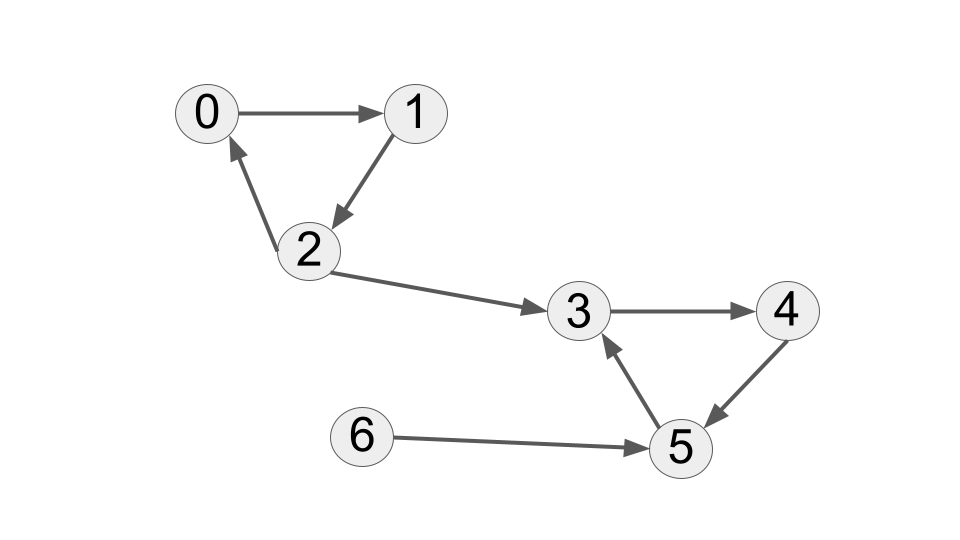

In [18]:
let n: usize = 7;
let edges: ListOfEdges = vec![(0,1),(1,2),(2,0),(3,4),(4,5),(5,3),(2,3),(6,5)];
let graph = Graph::create_directed(n, &edges);
let graph_reverse = Graph::create_directed(n,&reverse_edges(&edges));
println!("{:?}\n{:?}",graph,graph_reverse);

Graph { n: 7, outedges: [[1], [2], [0, 3], [4], [5], [3], [5]] }
Graph { n: 7, outedges: [[2], [0], [1], [2, 5], [3], [4, 6], []] }


## Implementation (first DFS)

In [19]:
let mut stack: Vec<Vertex> = Vec::new();
let mut visited = vec![false;graph.n];

In [20]:
fn dfs_collect_stack(v:Vertex, graph:&Graph, stack:&mut Vec<Vertex>, visited:&mut Vec<bool>) {
    if !visited[v] {
        visited[v] = true;
        for w in graph.outedges[v].iter() {
            dfs_collect_stack(*w, graph, stack, visited);
        }
        stack.push(v);
        println!("pushed {}", v);
    }
}

In [21]:
for v in 0..graph.n {
    dfs_collect_stack(v,&graph,&mut stack,&mut visited);
};
stack

pushed 5
pushed 4
pushed 3
pushed 2
pushed 1
pushed 0
pushed 6


[5, 4, 3, 2, 1, 0, 6]

## Implementation (second DFS, reversed graph)

In [22]:
let mut component: Vec<Option<Component>> = vec![None;graph.n];
let mut component_count = 0;

while let Some(v) = stack.pop() {
    if let None = component[v] {
        component_count += 1;
        mark_component_dfs(v, &graph_reverse, &mut component, component_count);
    }
};

In [23]:
print!("{} components:\n",component_count);
for c in 1..=component_count {
    print!("Component {}: ", c);
    for v in 0..n {
       if component[v].unwrap() == c {
          print!("{} ",v);
       }
    }
    println!();
}
println!();

3 components:
Component 1: 6 
Component 2: 0 1 2 
Component 3: 3 4 5 



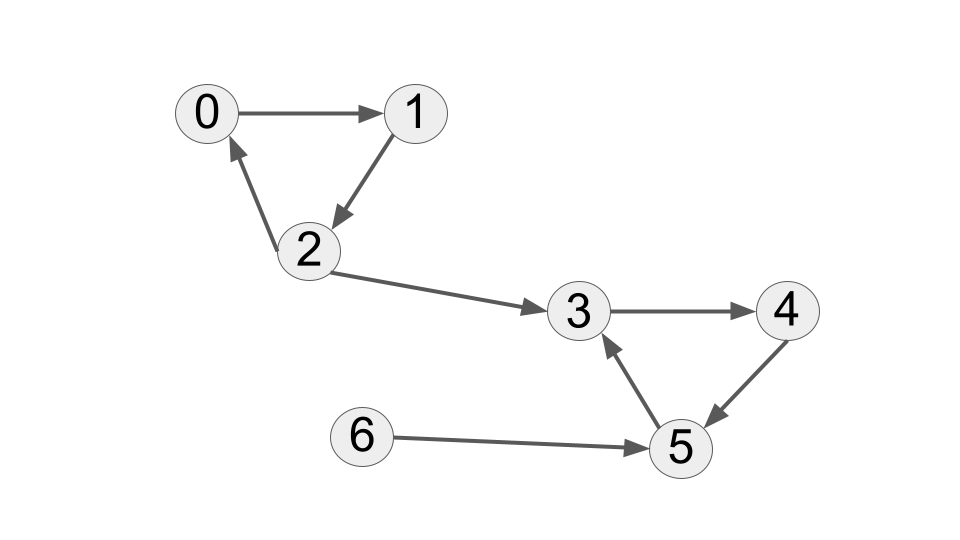

# <font color="red">Code formatting</font>

## Don't give up on code formatting!

* Rust doesn't require any specific indentation
* Still a good idea to make your code readable

In [2]:
//This is bad code 
fn h(z:i32)->i32{
     let mut t=0.max(z.min(1)-0.max(z-1));
     for y in 1..=2.min(z){
         t+=h(z-y)
     }
     t
}

In [3]:
//This is even worse code 
fn g(z:i32)->i32{let mut t=0.max(z.min(1)-0.max(z-1));for y in 1..=2.min(z){t+=g(z-y)}t}

In [4]:
// This is good code
fn f(z:i32)->i32 {
    let t;
    if z==0{
        t = 0;
    } else if z == 1 {
        t = 1;
    } else {
        t = f(z-1) + f (z-2);
    }
    t
}

In [5]:
for i in 0..10 {
    println!("{}:{},{},{}",i,h(i),g(i),f(i));
};

0:0,0,0
1:1,1,1
2:1,1,1
3:2,2,2
4:3,3,3
5:5,5,5
6:8,8,8
7:13,13,13
8:21,21,21
9:34,34,34


## Tool for formatting Rust code: `rustfmt`

* If you have Rust installed, you should already have it.

* `rustfmt [filename]` replaces the file with nicely formatted version
   * use `rustfmt --backup [filename]` to save the original file

<div align="center">
    <b>[see demo with comparison via kdiff3]</b>
</div>

* `rustfmt --help`: see the command line parameters
* `rustfmt --print-config default`: default config that can be adjusted

# 1. Code formatting
# <font color="red">2. Priority queues</font>
# 3. Popular implementation: binary heap

## Priority queues

**Standard queue:**

* things returned in order in which they were inserted

**Priority queue:**
  * items have priorities
  * highest priority items returned first

## Rust standard library implementation: `BinaryHeap<T>`

<br>

* Priorities provided by the ordering of elements of `T` (via trait `Ord`)


<br>
<br>

* Method `push(T)`:<br>push element onto the heap

<br>
<br>


* Method `pop() -> Option<T>`:<br>remove the greatest and return it

In [6]:
use std::collections::BinaryHeap;

let mut pq = BinaryHeap::new();

pq.push(2);
pq.push(7);
pq.push(3);

println!("{:?}",pq.pop());
println!("{:?}",pq.pop());

pq.push(3);
pq.push(4);

println!("\n{:?}",pq.pop());
println!("{:?}",pq.pop());
println!("{:?}",pq.pop());
println!("{:?}",pq.pop());

Some(7)
Some(3)

Some(4)
Some(3)
Some(2)
None


## Getting the smallest element out first

`Reverse<T>`: wrapper that reverses the ordering of elements of a type

In [7]:
3 < 4

true

In [8]:
use std::cmp::Reverse;
Reverse(3) < Reverse(4)

false

In [9]:
5 < 3

false

In [10]:
Reverse(5) < Reverse(3)

true

In [11]:
let mut pq = BinaryHeap::new();

pq.push(Reverse(3));
pq.push(Reverse(1));
pq.push(Reverse(7));

println!("{:?}",pq.pop());
println!("{:?}",pq.pop());

pq.push(Reverse(0));

println!("\n{:?}",pq.pop());

Some(Reverse(1))
Some(Reverse(3))

Some(Reverse(0))


## Default lexicographic ordering on tuples and structs

Lexicographic ordering:
* Compare first elements
* If equal, compare second elements
* If equal, compare third elements...

### Tuples

In [12]:
(3,4) < (2,7)

false

In [13]:
(11,2,7) < (11,3,4)

true

### Struct (derive `Ord`)

In [14]:
#[derive(PartialEq,Eq,PartialOrd,Ord,Debug)]
struct Point {
    x: i32,
    y: i32,
}

In [15]:
let p = Point{x:3,y:4};
let q = Point{x:2,y:7};
println!("{}", p < q);
println!("{}", p > q);

false
true


## Another option: implement your own comparison

* More complicated, see below

* See the documentation for `Ord` or examples online

In [16]:
#[derive(PartialEq,Eq,Ord,Debug)]
struct Point2 {
    x: i32,
    y: i32,
}

// Let's assume we want to compare point by their distance to the origin
impl std::cmp::PartialOrd for Point2 {
    fn partial_cmp(&self, other: &Self) -> Option<std::cmp::Ordering> {
        let this = self.x * self.x + self.y * self.y;
        let that = other.x * other.x + other.y * other.y;
        return this.partial_cmp(&that);
    }
}


In [17]:
let p = Point2{x:3,y:1};
let q = Point2{x:2,y:100};
println!("{}", p < q);
println!("{}", p > q);

true
false


## How to implement a priority queue?
Assumptions:
 * At most $n$ elements
 * Comparison takes $O(1)$ time

### Straighforward

Representation: a vector of elements

Push:
* add to the end of the vector
* Time complexity: $O(1)$ (amortized) time

Pop:
* go over all elements, select the greatest
* Time complexity: $O(n)$